In [8]:
from itertools import chain, cycle, groupby
from queries import Mast, Simbad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from astropy import units as u
from astropy.coordinates import SkyCoord
import time

% matplotlib inline

def filtr(name):
    return (name.startswith('LINEAR')==False and
            name.startswith('SKY') == False and
            name.startswith('ADS') == False and
            'JUP' not in name
           )

In [5]:
gratings=('E140H','E140M','E230H','E230M')
stis_results=list(chain(*[Mast.STISSearch(grating=x) for x in gratings]))
print len(stis_results)

5599


In [15]:
#stis_gals=SkyCoord(ra=[x.ra for x in stis_results]*u.degree, dec=[x.dec for x in stis_results]*u.degree).galactic
echelle_groups=[list(g) for k,g in groupby(stis_results, lambda x: x.grating)]

In [ ]:
cleaned_list=list(set([x for x in stis_results if filtr(x.target)]))
for star in cleaned_list:
    Simbad.CoordSearch(star.ra, star.dec, 1)

In [ ]:

# Old, bad way of searching for HD identifiers
for star in cleaned_list:
    print star,
    star=star.replace('CENTRE','')
    star=star.replace('V-', 'V*-')
    star=star.replace('EM-','EM*-')
    if star == 'NGC346-12':
        star = 'Cl* NGC 346 MPG 12'
    if star.startswith('BD'):
        star=star.replace('BD-','BD-+')
    if star.startswith('SK') == False and star.startswith('EC')==False:
        star = star.replace('-',' ')
    if 'D' in star:
        if (star.startswith('BD') or star.startswith('HD')) and ('D' in star[2:]):
            d_idx=star[2:].index('D')+2
        else:
            d_idx=star.index('D')
        if d_idx != (len(star)-1) and star[d_idx-1].isdigit() and star[d_idx+1].isdigit():
            star = star[:d_idx]+' '+star[d_idx+1:]
    print [x for x in Simbad.IDList(star) if x.startswith('HD')]

In [ ]:
# Simbad regions have to be <=600 sq deg
# Do 6 searches of 60 x 10 (l x b) boxes centered on galactic plane
sim_results=[]
for i in range(12):
    start=time.time()
    cen_l=str(345.-30.*i)
    print 'Searching around',cen_l,
    critstring=('region(box,gal,'+cen_l+' +0, 1800 1200) '
                '& cat=HD '
                '& sptype <= B9 '
                '& Vmag < 8'
                )
    sim_results=sim_results+Simbad.CritSearch(critstring, mx=10000, get_pms=True, get_plx=True)
    print 'took',round(time.time()-start,2), 'seconds.'
print 'Total results:',len(sim_results)

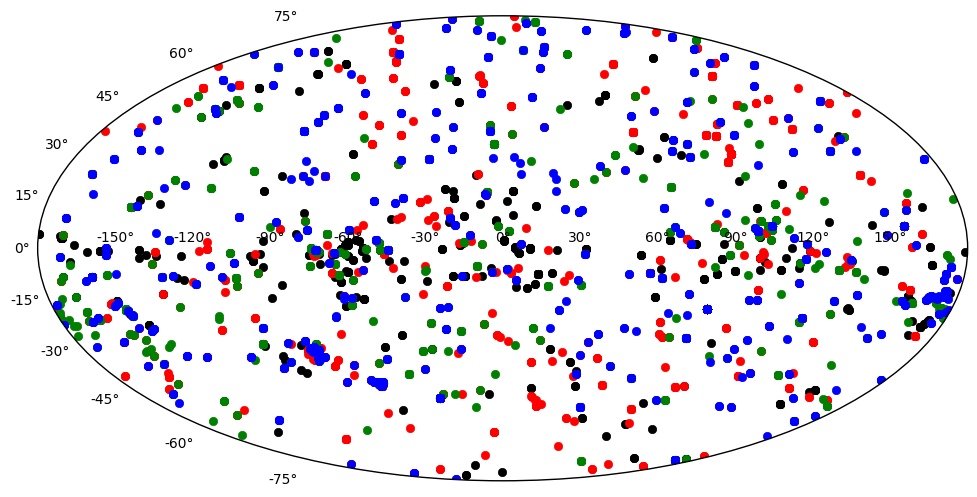

In [25]:
ech_map={
    'E140H':'k',
    'E140M':'r',
    'E230H':'g',
    'E230M':'b'
    }
fig=plt.figure(1,figsize=(12,9))
subplt=plt.subplot(111,projection='mollweide')

for k,g in groupby(stis_results, lambda x: x.grating):
    ech=list(g)
    coords=SkyCoord(ra=[i.ra for i in ech]*u.degree,dec=[j.dec for j in ech]*u.degree).galactic
    subplt.plot(coords.l.wrap_at(180*u.degree)*np.pi/180., coords.b*np.pi/180., 'o', color=ech_map[k], mec=ech_map[k])

In [ ]:
fig2=plt.figure(2, figsize=(12,3))
majorLocator = MultipleLocator(30)

subplt2=plt.subplot(111)
for g in (e140h,e140m,e230h,e230m):
    c=col.next()
    subplt2.plot(g.l.wrap_at(180*u.degree),g.b, 'o', ms=4,color=c,mec=c)
    
subplt2.set_ylim(-10,10)
subplt2.xaxis.set_major_locator(majorLocator)
plt.grid()
plt.savefig('echelle_galactic_plane.pdf')